# **ANÁLISE PREDITIVA DE VENDAS DO PRIMEIRO TRIMESTRE DE 2024**



---



**Objetivo:** Obter com um modelo de aprendizado de máquina simples uma projeção da quantidade de vendas pro primeiro trimestre do ano seguinte (2024) ao que a base original se refere

**Metodologia:** Será treinados dois modelos para projetar os próximos meses (Rnadom Forest e Linear Regression). Para isso, será necessário:

1.   Criar variável que diferencie cada produto

2.   Criar variáveis que calcule preço de venda e custo unitário

3.   Preparar os dados (Encoding) para melhor performance dos algoritmos

4.   Utilizar métricas como RMSE (raiz do erro quadrático médio) para avaliar performance desses modelos de regressão, uma vez que iremos estimar valores quantitativos.

5.   Criar uma base que simule vendas nos meses de Janeiro, Fevereio e Março de 2024, com dados baseados nos reais

6. Calcular Receita, custo, lucro e margem baseada na previsão da quantidade vendida, preço e custo unitário e ajuste de inflação reportada pelo Banco Central do ano de 2023


[*IPCA fecha 2023 em 4,62%,*](https://agenciagov.ebc.com.br/noticias/202401/ipca-chega-a-0-56-em-dezembro-e-fecha-o-ano-em-4-62-2) *dentro da meta da inflação do* [*Conselho Monetário Nacional*](https://www.bcb.gov.br/content/ri/relatorioinflacao/202403/ri202403b4p.pdf)

#1 imports e configurações

Bibliotecas de códigos e conexão com o drive que serão necessárias para fazer a análise preditiva

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

#2 Extraindo os dados

In [ ]:
#extraindo os dados
path = '/content/drive/MyDrive/Codes/unimed/base_dados_teste_analista.csv'
df = pd.read_csv(path)

In [ ]:
df.sample(10)

,Data da Venda,Produto,Categoria,Quantidade Vendida,Receita,Custo,Localidade,Vendedor,Lucro,Margem de Lucro (%),item,mes,preco,custo_unitario
285,2023-09-11,Produto C,Eletrônicos,18,847.48,154.42,Curitiba,Mariana,693.06,81.78,Eletrônicos C,9,47.08,8.58
994,2023-11-16,Produto A,Roupas,13,884.84,125.65,Curitiba,João,759.19,85.80,Roupas A,11,68.06,9.67
235,2023-05-04,Produto D,Brinquedos,16,549.40,468.77,Belo Horizonte,Mariana,80.63,14.68,Brinquedos D,5,34.34,29.30
274,2023-07-27,Produto A,Roupas,13,132.01,423.23,Rio de Janeiro,Ana,-291.22,-220.60,Roupas A,7,10.15,32.56
499,2023-12-02,Produto D,Alimentos,9,808.94,142.43,São Paulo,Ana,666.51,82.39,Alimentos D,12,89.88,15.83
522,2023-08-30,Produto C,Brinquedos,5,593.95,283.87,Belo Horizonte,João,310.08,52.21,Brinquedos C,8,118.79,56.77
369,2023-10-26,Produto D,Eletrônicos,6,768.11,282.05,Curitiba,Ana,486.06,63.28,Eletrônicos D,10,128.02,47.01
915,2023-05-25,Produto B,Alimentos,6,579.03,328.34,Curitiba,João,250.69,43.29,Alimentos B,5,96.50,54.72
340,2023-10-29,Produto A,Eletrônicos,11,585.60,242.38,Belo Horizonte,Ana,343.22,58.61,Eletrônicos A,10,53.24,22.03
794,2023-10-13,Produto D,Alimentos,8,894.03,96.66,São Paulo,Ana,797.37,89.19,Alimentos D,10,111.75,12.08


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Data da Venda        1000 non-null   object 
 1   Produto              1000 non-null   object 
 2   Categoria            1000 non-null   object 
 3   Quantidade Vendida   1000 non-null   int64  
 4   Receita              1000 non-null   float64
 5   Custo                1000 non-null   float64
 6   Localidade           1000 non-null   object 
 7   Vendedor             1000 non-null   object 
 8   Lucro                1000 non-null   float64
 9   Margem de Lucro (%)  1000 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 78.2+ KB


# 3 Feature Engineering

Criando as variáveis descritais na metodologia

In [ ]:
#criando coluna item que combina categoria + produto tipo A, B, C ou D
df['item'] = df['Categoria'] + df['Produto']

#removendo a palavra 'Produto' de 'item'
df['item'] = df['item'].str.replace('Produto', '')

#tranformando 'Data da Venda' em datetime
df['Data da Venda'] = pd.to_datetime(df['Data da Venda'])

#criando a variável 'mes' a partir da 'Data da Venda'
df['mes'] = df['Data da Venda'].dt.month

#criando valores de preço e custo unitários
df['preco'] = (df['Receita'] / df['Quantidade Vendida']).round(2)
df['custo_unitario'] = (df['Custo'] / df['Quantidade Vendida']).round(2)

#definindo ajuste devido à inflação de 2023 para 2024
inflacao = 1.0462

#4 Encoding

Preparando os dados pro modelos.É necessário passar as informações qualitativas e cíclicas em números.

In [ ]:
data = df[['Data da Venda', 'item', 'Localidade', 'Vendedor', 'Quantidade Vendida']].copy()
data.columns = ['data', 'item', 'localidade', 'vendedor', 'qtd_vendida']

analisando a distribuição, conclui-se que será só necessário fazer transformação de Log para o algoritmo Linear Regression, característico do mesmo

count    1000.000000
mean        9.950000
std         5.489046
min         1.000000
25%         5.000000
50%        10.000000
75%        15.000000
max        19.000000
Name: qtd_vendida, dtype: float64


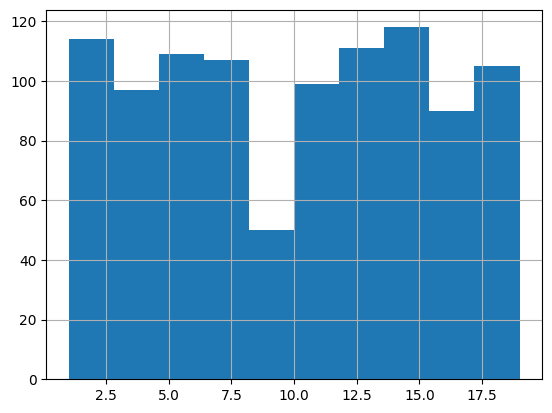

In [ ]:
#histograma de distribuição de demanda
print(data['qtd_vendida'].describe())
data['qtd_vendida'].hist();

In [ ]:
#aplicando one hot encoding em localidade, vendedor e item
data = pd.get_dummies(data, columns=['localidade', 'vendedor', 'item'])

#mudar True para 1 e False para 0
data = data.astype(int)

#criando target transformada
data['qtd_vendida_log'] = np.log(data['qtd_vendida'] + 1)

#transformação cíclica dos dias
data['dia_sin'] = data['data'].apply( lambda x: np.sin( x * ( 2. * np.pi/365 )))
data['dia_cos'] = data['data'].apply( lambda x: np.cos( x * ( 2. * np.pi/365 )))

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       1000 non-null   int64  
 1   qtd_vendida                1000 non-null   int64  
 2   localidade_Belo Horizonte  1000 non-null   int64  
 3   localidade_Curitiba        1000 non-null   int64  
 4   localidade_Rio de Janeiro  1000 non-null   int64  
 5   localidade_São Paulo       1000 non-null   int64  
 6   vendedor_Ana               1000 non-null   int64  
 7   vendedor_Carlos            1000 non-null   int64  
 8   vendedor_João              1000 non-null   int64  
 9   vendedor_Mariana           1000 non-null   int64  
 10  item_Alimentos A           1000 non-null   int64  
 11  item_Alimentos B           1000 non-null   int64  
 12  item_Alimentos C           1000 non-null   int64  
 13  item_Alimentos D           1000 non-null   int64 

#5 Criando Modelo

Nessa etapa é necessáro subdividir os dados, 80% para treino, pois não há tantos dados, e 20% para validação

In [ ]:
#divindo modelo para treinamento e teste aleatóriamente
X1 = data.drop(columns=['qtd_vendida', 'qtd_vendida_log', 'data'])
y1 = data['qtd_vendida']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

X2 = data.drop(columns=['qtd_vendida', 'qtd_vendida_log', 'data'])
y2 = data['qtd_vendida_log']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [ ]:
#aplicando random forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train1, y_train1)
y_pred_rf = rf_model.predict(X_test1)

# Avaliar o modelo
mse_rf = mean_squared_error(y_test1, y_pred_rf)
rmse_rf = mean_squared_error(y_test1, y_pred_rf)**0.5
print(f'MSE Random Forest: {mse_rf}')
print(f'RMSE Random Forest: {rmse_rf}')

MSE Random Forest: 31.84518410175737
RMSE Random Forest: 5.643153737207358


In [ ]:
#aplicando linear regression
lr_model = LinearRegression()
lr_model.fit(X_train2, y_train2)
y_pred_lr = lr_model.predict(X_test2)

#transformando resultado
y_test2 = np.round(np.exp(y_test2) - 1)
y_pred_lr = np.round(np.exp(y_pred_lr) - 1)

# Avaliar o modelo
mse_lr = mean_squared_error(y_test2, y_pred_lr)
rmse_lr = mean_squared_error(y_test2, y_pred_lr)**0.5
print(f'MSE Linear Regression: {mse_lr}')
print(f'RMSE Linear Regression: {rmse_lr}')

MSE Linear Regression: 30.81
RMSE Linear Regression: 5.550675634551167


In [ ]:
print(rmse_lr - rmse_rf)
print(mse_lr - mse_rf)

-0.09247810265619094
-1.0351841017573697


Apesar de uma pequena melhor performance do Linear Regression. Será utilizado o **Random Forest** uma vez que nele não é necessário fazer transformação de Log na variável a ser prevista, o que **facilita o entendimento dos resultados, bem como, o procedimento**.

#6 Construindo base para a previsão

In [ ]:
#a base de previsão será a demanda do ano anterior até fim de março (mes 3)
treino = df[['Data da Venda', 'item', 'Localidade', 'Vendedor']]
previsao = df[['Data da Venda', 'item', 'Localidade', 'Vendedor']][df['Data da Venda'] < '2023-04-01']
treino.columns = ['data', 'item', 'localidade', 'vendedor']
previsao.columns = ['data', 'item', 'localidade', 'vendedor']

In [ ]:
treino

,data,item,localidade,vendedor
0,2023-04-13,Roupas B,São Paulo,Mariana
1,2023-12-15,Alimentos D,Belo Horizonte,Mariana
2,2023-09-28,Brinquedos B,São Paulo,João
3,2023-04-17,Brinquedos D,Curitiba,Carlos
4,2023-03-13,Alimentos A,São Paulo,João
...,...,...,...,...
995,2023-02-07,Eletrônicos C,Rio de Janeiro,Mariana
996,2023-10-20,Roupas D,Belo Horizonte,Ana
997,2023-05-19,Eletrônicos C,Belo Horizonte,João
998,2023-12-22,Eletrônicos B,Curitiba,Mariana


In [ ]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        1000 non-null   datetime64[ns]
 1   item        1000 non-null   object        
 2   localidade  1000 non-null   object        
 3   vendedor    1000 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 31.4+ KB


In [ ]:
previsao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, 4 to 995
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        228 non-null    datetime64[ns]
 1   item        228 non-null    object        
 2   localidade  228 non-null    object        
 3   vendedor    228 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 8.9+ KB


In [ ]:
#adicionando um ano nos dados de previsao
previsao['data'] = previsao['data'] + pd.DateOffset(years=1)

In [ ]:
previsao

,data,item,localidade,vendedor
4,2024-03-13,Alimentos A,São Paulo,João
6,2024-01-21,Brinquedos D,Rio de Janeiro,Ana
11,2024-03-29,Brinquedos D,Rio de Janeiro,João
25,2024-01-22,Alimentos C,Belo Horizonte,Carlos
29,2024-02-18,Brinquedos A,Curitiba,Mariana
...,...,...,...,...
987,2024-01-20,Eletrônicos C,Curitiba,Ana
990,2024-02-16,Roupas D,São Paulo,Mariana
991,2024-01-01,Eletrônicos A,Rio de Janeiro,João
992,2024-03-31,Roupas D,Belo Horizonte,Ana


In [ ]:
#concatenando treino e previsao
base = pd.concat([treino, previsao])

In [ ]:
base

,data,item,localidade,vendedor
0,2023-04-13,Roupas B,São Paulo,Mariana
1,2023-12-15,Alimentos D,Belo Horizonte,Mariana
2,2023-09-28,Brinquedos B,São Paulo,João
3,2023-04-17,Brinquedos D,Curitiba,Carlos
4,2023-03-13,Alimentos A,São Paulo,João
...,...,...,...,...
987,2024-01-20,Eletrônicos C,Curitiba,Ana
990,2024-02-16,Roupas D,São Paulo,Mariana
991,2024-01-01,Eletrônicos A,Rio de Janeiro,João
992,2024-03-31,Roupas D,Belo Horizonte,Ana


In [ ]:
#salvando base a ser prevista
pasta = '/content/drive/MyDrive/Codes/unimed/'
base.to_csv(pasta + 'base.csv', index=False)

#7 prevendo vendas

In [ ]:
#extraindo previsao
primeiro_trimestre = pd.read_csv(pasta + 'base.csv')

In [ ]:
#encoding da previsão
previsao = pd.get_dummies(primeiro_trimestre, columns=['localidade', 'vendedor', 'item'])

In [ ]:
previsao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   data                       1228 non-null   object
 1   localidade_Belo Horizonte  1228 non-null   bool  
 2   localidade_Curitiba        1228 non-null   bool  
 3   localidade_Rio de Janeiro  1228 non-null   bool  
 4   localidade_São Paulo       1228 non-null   bool  
 5   vendedor_Ana               1228 non-null   bool  
 6   vendedor_Carlos            1228 non-null   bool  
 7   vendedor_João              1228 non-null   bool  
 8   vendedor_Mariana           1228 non-null   bool  
 9   item_Alimentos A           1228 non-null   bool  
 10  item_Alimentos B           1228 non-null   bool  
 11  item_Alimentos C           1228 non-null   bool  
 12  item_Alimentos D           1228 non-null   bool  
 13  item_Brinquedos A          1228 non-null   bool  
 14  item_Bri

Seguimos com os ajustes de transformar todas as variáveis em informação numérica para aplicar o algoritmo e, em seguida, iremos agragar a previsão aos dados reais

In [ ]:
#transformando todos os valores True em 1, e False em 0
for column in previsao.select_dtypes(include=['bool']).columns:
    previsao[column] = previsao[column].astype(int)


#transformação cíclica dos dias
previsao['data'] = pd.to_datetime(previsao['data'])
previsao['ano'] = previsao['data'].dt.year
previsao['mes'] = previsao['data'].dt.month
previsao['mes_sin'] = np.sin(2 * np.pi * previsao['mes'] / 12)
previsao['mes_cos'] = np.cos(2 * np.pi * previsao['mes'] / 12)

#separando por ano
train = previsao[previsao['ano'] == 2023]
prev = previsao[previsao['ano'] == 2024]

train['qtd_vendida'] = df['Quantidade Vendida']

#prevendo
X_train = train.drop(columns=['qtd_vendida', 'data', 'ano', 'mes'])
y_train = train['qtd_vendida']
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
X_prev = prev.drop(columns=['data', 'ano', 'mes'])
y_prev = rf_model.predict(X_prev)

#agrgando os dados previstos
prev['qtd_vendida'] = y_prev.round(0).astype(int)

#juntando reais e previstos
qtd_vendida = pd.concat([train['qtd_vendida'], prev['qtd_vendida']])
primeiro_trimestre['qtd_vendida'] = qtd_vendida

#separando o 1º trimestree de 2024
primeiro_trimestre = primeiro_trimestre[primeiro_trimestre['data'] > '2023-12-31']

#renomeando colunas para que combinem com a base original
primeiro_trimestre.columns = ['Data da Venda', 'item',  'Localidade', 'Vendedor', 'Quantidade Vendida']

#transformando Data de venda em datetime
primeiro_trimestre['Data da Venda'] = pd.to_datetime(primeiro_trimestre['Data da Venda'])

#criando a variável 'mes' a partir da 'Data da Venda'
primeiro_trimestre['mes'] = primeiro_trimestre['Data da Venda'].dt.month

Agregado os dados previstos, podemos fazer os últimos calculos, como descrito na metodologia

In [ ]:
#estipulando o mesmo preço e custo unitário a primeir_trimestre baseado em df ('item', 'localidade', 'mes', e 'vendedor' )
primeiro_trimestre = primeiro_trimestre.merge(df[['item', 'Localidade', 'mes', 'Vendedor', 'preco', 'custo_unitario']], on=['item', 'Localidade', 'mes', 'Vendedor'], how='left')

#calculando receita
primeiro_trimestre['Receita'] = (primeiro_trimestre['Quantidade Vendida'] * primeiro_trimestre['preco'] * inflacao).round(2)

#calculando custo
primeiro_trimestre['Custo'] = (primeiro_trimestre['Quantidade Vendida'] * primeiro_trimestre['custo_unitario'] * inflacao).round(2)

#calculando lucro
primeiro_trimestre['Lucro'] = (primeiro_trimestre['Receita'] - primeiro_trimestre['Custo']).round(2)

#calculando margem
primeiro_trimestre['Margem'] = ((primeiro_trimestre['Lucro'] / primeiro_trimestre['Receita'])*100).round(2)

#juntando tudo
final = pd.concat([df, primeiro_trimestre])

#salvando final
final.to_excel(pasta + 'projecao.xlsx', index=False)